In [1]:
%%capture
!cp /kaggle/input/rcnnutils/engine.py .
!cp /kaggle/input/rcnnutils/utils.py .
!cp /kaggle/input/rcnnutils/coco_eval.py .
!cp /kaggle/input/rcnnutils/coco_utils.py .
!cp /kaggle/input/rcnnutils/transforms.py .
!mkdir -p /root/.cache/torch/checkpoints
!cp /kaggle/input/resnet50/resnet50-19c8e357.pth /root/.cache/torch/checkpoints/
!cp /kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl .
!pip install pycocotools-2.0-cp37-cp37m-linux_x86_64.whl

In [2]:
import os
import ast
import numpy as np
import pandas as pd

import gc
import cv2
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import matplotlib.pyplot as plt

import utils
from engine import train_one_epoch, evaluate

In [3]:
DATA_DIR = '/kaggle/input/global-wheat-detection'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
DETECTION_THRESHOLD = 0.40

In [4]:
def get_train_df():
    train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

    # Let's expand the bounding box coordinates and calculate the area of all the bboxes
    train_df[['x_min','y_min', 'width', 'height']] = pd.DataFrame([ast.literal_eval(x) for x in train_df.bbox.tolist()], index= train_df.index)
    train_df = train_df[['image_id', 'bbox', 'source', 'x_min', 'y_min', 'width', 'height']]
    train_df = train_df.drop(['bbox', 'source'], axis=1)
    return train_df
train_df = get_train_df()

In [5]:
# train_df = train_df.iloc[:2000]

In [6]:
sample_sub_df = pd.read_csv(os.path.join(DATA_DIR, 'sample_submission.csv'))
sample_sub_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [7]:
def get_model(pre_trained=True):
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pre_trained)

    # replace the classifier with a new one, that has
    # num_classes which is user-defined
    num_classes = 2  # 1 class (wheat heads) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
%%capture
model = get_model(pre_trained=False)
model.to(DEVICE)
model.load_state_dict(torch.load(f'/kaggle/input/wheatdetectionfasterrcnn/seresnext_ls_fold0.pth', map_location=DEVICE))

# Setting model in evaluation mode for getting pseudo labels
model.eval()

In [9]:
class WheatDatasetTest(Dataset):
    
    def __init__(self, image_ids):
        self.image_ids = image_ids
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index][:-4]
        image = cv2.imread(os.path.join(DATA_DIR, 'test', f'{image_id}.jpg'), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)

        return image_id, image

In [10]:
def collate_fn(batch):
    return tuple(zip(*batch))


def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

## Predict on unseen test dataset and get the labels

In [11]:
def get_pseudo_labels(test_data_loader):
    model.eval()
    model.to(DEVICE)
    pseudo_labels = []

    for image_ids, images in test_data_loader:

        images = list(image.to(DEVICE) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            boxes = boxes[scores >= DETECTION_THRESHOLD].astype(np.int32)
            scores = scores[scores >= DETECTION_THRESHOLD]
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            for box in boxes:
                pseudo_labels.append({
                'image_id': image_id,
                'x_min': box[0],
                'y_min': box[1],
                'width': box[2],
                'height': box[3]
            })
    pseudo_train_df = pd.DataFrame(pseudo_labels)
    return pseudo_train_df

In [12]:
test_dataset = WheatDatasetTest(os.listdir(os.path.join(DATA_DIR, 'test')))

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [13]:
pseudo_train_df = get_pseudo_labels(test_data_loader)

## We got pseudo labels! Now let's retrain the same model with all the training data as well as all the pseudo labels

In [14]:
train_df = pd.concat([train_df, pseudo_train_df]).reset_index(drop=True)
train_df.tail()

,image_id,x_min,y_min,width,height
148036,53f253011,578.0,580.0,80.0,133.0
148037,53f253011,296.0,610.0,125.0,97.0
148038,53f253011,928.0,819.0,94.0,201.0
148039,53f253011,527.0,399.0,73.0,70.0
148040,53f253011,141.0,618.0,87.0,126.0


In [15]:
# There are some huge bounding boxes in the training dataset. Let's get rid of them
train_df = train_df[train_df['height'] * train_df['width'] < 100000].reset_index(drop=True)
train_df['area'] = train_df['width'] * train_df['height']
train_df.head()

,image_id,x_min,y_min,width,height,area
0,b6ab77fd7,834.0,222.0,56.0,36.0,2016.0
1,b6ab77fd7,226.0,548.0,130.0,58.0,7540.0
2,b6ab77fd7,377.0,504.0,74.0,160.0,11840.0
3,b6ab77fd7,834.0,95.0,109.0,107.0,11663.0
4,b6ab77fd7,26.0,144.0,124.0,117.0,14508.0


In [16]:
class WheatDatasetTrain(Dataset):
    def __init__(self, df):
        self.df = df
        self.image_ids = train_df['image_id'].unique()
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        
        path = os.path.join(DATA_DIR, 'train', f'{image_id}.jpg')
        if not os.path.isfile(os.path.join(DATA_DIR, 'train', f'{image_id}.jpg')):
            path = os.path.join(DATA_DIR, 'test', f'{image_id}.jpg')

        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        # Convert from NHWC to NCHW as pytorch expects images in NCHW format
        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image)
        
        # Get bbox coordinates for each wheat head(s)
        bboxes_df = self.df[self.df['image_id'] == image_id]
        boxes, areas = [], []
        n_objects = len(bboxes_df)  # Number of wheat heads in the given image

        for i in range(n_objects):
            x_min = bboxes_df.iloc[i]['x_min']
            x_max = x_min + bboxes_df.iloc[i]['width']
            y_min = bboxes_df.iloc[i]['y_min']
            y_max = y_min + bboxes_df.iloc[i]['height']
            boxes.append([x_min, y_min, x_max, y_max])
            areas.append(bboxes_df.iloc[i]['area'])
            
        
        # Convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Get the labels. We have only one class (wheat head)
        labels = torch.ones((n_objects, ), dtype=torch.int64)
        
        areas = torch.as_tensor(areas)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((n_objects, ), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([index]),
            'area': areas,
            'iscrowd': iscrowd
        }

        return image, target

In [17]:
def train(train_df):
    model.train()
    model.to(DEVICE)

    # our dataset has two classes only - background and wheat heads
    num_classes = 2

    # use our dataset and defined transformations
    dataset = WheatDatasetTrain(train_df)
    dataset_test = WheatDatasetTrain(train_df)

    # split the dataset in train and test set
    indices = torch.randperm(len(dataset)).tolist()
    dataset = torch.utils.data.Subset(dataset, indices[:-50])
    dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

    # define training and validation data loaders
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=16, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=16, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 4 epochs
    num_epochs = 4

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, DEVICE, epoch, print_freq=10)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_test, device=DEVICE)

In [18]:
train(train_df)

Epoch: [0]  [  0/209]  eta: 0:33:05  lr: 0.000006  loss: 0.5872 (0.5872)  loss_classifier: 0.2082 (0.2082)  loss_box_reg: 0.2050 (0.2050)  loss_objectness: 0.0463 (0.0463)  loss_rpn_box_reg: 0.1277 (0.1277)  time: 9.4989  data: 5.9334  max mem: 11473
Epoch: [0]  [ 10/209]  eta: 0:09:32  lr: 0.000054  loss: 0.5793 (0.5795)  loss_classifier: 0.2063 (0.2048)  loss_box_reg: 0.1907 (0.1951)  loss_objectness: 0.0463 (0.0485)  loss_rpn_box_reg: 0.1277 (0.1311)  time: 2.8783  data: 0.6666  max mem: 11736
Epoch: [0]  [ 20/209]  eta: 0:07:52  lr: 0.000102  loss: 0.5718 (0.5758)  loss_classifier: 0.2021 (0.2065)  loss_box_reg: 0.1907 (0.1959)  loss_objectness: 0.0413 (0.0446)  loss_rpn_box_reg: 0.1272 (0.1289)  time: 2.1501  data: 0.1209  max mem: 11736
Epoch: [0]  [ 30/209]  eta: 0:07:06  lr: 0.000150  loss: 0.5510 (0.5702)  loss_classifier: 0.2003 (0.2039)  loss_box_reg: 0.1903 (0.1938)  loss_objectness: 0.0393 (0.0431)  loss_rpn_box_reg: 0.1276 (0.1294)  time: 2.1140  data: 0.1192  max mem: 11

## Pseudo Labeling Round #2

In [19]:
pseudo_train_df = get_pseudo_labels(test_data_loader)
train_df = get_train_df()
train_df = pd.concat([train_df, pseudo_train_df]).reset_index(drop=True)

# There are some huge bounding boxes in the training dataset. Let's get rid of them
train_df = train_df[train_df['height'] * train_df['width'] < 100000].reset_index(drop=True)
train_df['area'] = train_df['width'] * train_df['height']
train(train_df)

Epoch: [0]  [  0/209]  eta: 0:26:37  lr: 0.000006  loss: 0.5332 (0.5332)  loss_classifier: 0.1948 (0.1948)  loss_box_reg: 0.1856 (0.1856)  loss_objectness: 0.0418 (0.0418)  loss_rpn_box_reg: 0.1111 (0.1111)  time: 7.6437  data: 5.2716  max mem: 11737
Epoch: [0]  [ 10/209]  eta: 0:08:52  lr: 0.000054  loss: 0.5516 (0.5540)  loss_classifier: 0.1977 (0.2001)  loss_box_reg: 0.1982 (0.1951)  loss_objectness: 0.0390 (0.0378)  loss_rpn_box_reg: 0.1134 (0.1210)  time: 2.6747  data: 0.5831  max mem: 11737
Epoch: [0]  [ 20/209]  eta: 0:07:23  lr: 0.000102  loss: 0.5595 (0.5543)  loss_classifier: 0.2010 (0.1997)  loss_box_reg: 0.1974 (0.1949)  loss_objectness: 0.0375 (0.0385)  loss_rpn_box_reg: 0.1212 (0.1213)  time: 2.0824  data: 0.1082  max mem: 11737
Epoch: [0]  [ 30/209]  eta: 0:06:45  lr: 0.000150  loss: 0.5653 (0.5580)  loss_classifier: 0.2026 (0.2002)  loss_box_reg: 0.1970 (0.1936)  loss_objectness: 0.0377 (0.0393)  loss_rpn_box_reg: 0.1217 (0.1249)  time: 2.0438  data: 0.1244  max mem: 11

## Pseudo Labeling Round #3

In [20]:
pseudo_train_df = get_pseudo_labels(test_data_loader)
train_df = get_train_df()
train_df = pd.concat([train_df, pseudo_train_df]).reset_index(drop=True)

# There are some huge bounding boxes in the training dataset. Let's get rid of them
train_df = train_df[train_df['height'] * train_df['width'] < 100000].reset_index(drop=True)
train_df['area'] = train_df['width'] * train_df['height']
train(train_df)

Epoch: [0]  [  0/209]  eta: 0:29:30  lr: 0.000006  loss: 0.5866 (0.5866)  loss_classifier: 0.2068 (0.2068)  loss_box_reg: 0.2073 (0.2073)  loss_objectness: 0.0421 (0.0421)  loss_rpn_box_reg: 0.1304 (0.1304)  time: 8.4731  data: 6.0601  max mem: 11737
Epoch: [0]  [ 10/209]  eta: 0:09:15  lr: 0.000054  loss: 0.5319 (0.5368)  loss_classifier: 0.1938 (0.1942)  loss_box_reg: 0.1826 (0.1877)  loss_objectness: 0.0378 (0.0371)  loss_rpn_box_reg: 0.1164 (0.1178)  time: 2.7911  data: 0.6634  max mem: 11737
Epoch: [0]  [ 20/209]  eta: 0:07:50  lr: 0.000102  loss: 0.5181 (0.5318)  loss_classifier: 0.1872 (0.1923)  loss_box_reg: 0.1822 (0.1871)  loss_objectness: 0.0361 (0.0364)  loss_rpn_box_reg: 0.1152 (0.1159)  time: 2.1876  data: 0.1121  max mem: 11737
Epoch: [0]  [ 30/209]  eta: 0:06:59  lr: 0.000150  loss: 0.5196 (0.5268)  loss_classifier: 0.1906 (0.1922)  loss_box_reg: 0.1809 (0.1833)  loss_objectness: 0.0340 (0.0359)  loss_rpn_box_reg: 0.1131 (0.1154)  time: 2.0986  data: 0.1046  max mem: 11

## Final Prediction

In [21]:
model.eval()

results = []

for image_ids, images in test_data_loader:

    images = list(image.to(DEVICE) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= DETECTION_THRESHOLD].astype(np.int32)
        scores = scores[scores >= DETECTION_THRESHOLD]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [22]:
!rm -rf *

In [23]:
sub_df = pd.DataFrame(results)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()

,image_id,PredictionString
0,796707dd7,0.9860 508 785 86 91 0.9855 901 333 88 84 0.98...
1,cc3532ff6,0.9958 264 638 100 164 0.9954 5 411 146 105 0....
2,51f1be19e,0.9914 278 467 134 122 0.9860 505 463 199 106 ...
3,51b3e36ab,0.9954 869 284 153 145 0.9952 538 21 247 137 0...
4,f5a1f0358,0.9915 148 758 148 112 0.9898 291 457 158 102 ...


In [24]:
def get_bboxes(pred_str):
    span=5
    preds = pred_str.split()
    bboxes = [list(map(int, preds[i+1:i+span] )) for i in range(0, len(preds), span)]
    return bboxes

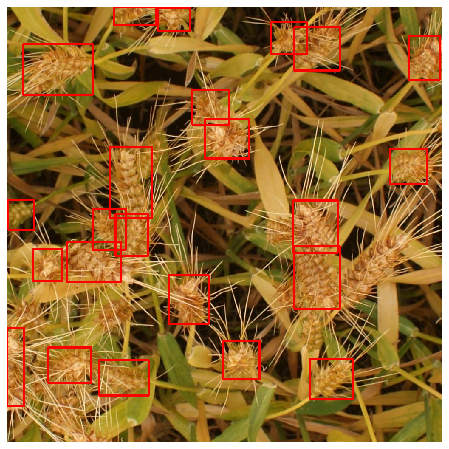

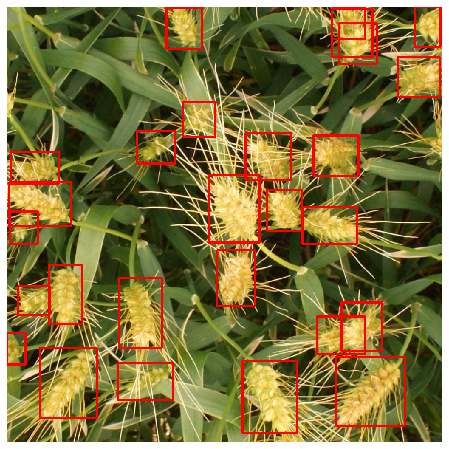

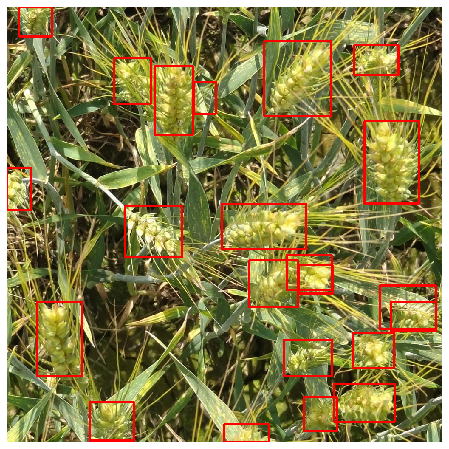

In [25]:
for image_id, pred_str in zip(sub_df.iloc[:3]['image_id'], sub_df.iloc[:3]['PredictionString']):
    image_path = os.path.join(DATA_DIR, 'test', f'{image_id}.jpg')
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    boxes = get_bboxes(pred_str)
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(image,
                      (box[0], box[1]),
                      (box[2] + box[0], box[3] + box[1]),
                      (255, 0, 0), 3)

    ax.set_axis_off()
    ax.imshow(image)
    plt.show()